#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
# 주어진 데이터 셋을 불러오세요.
train_df = pd.read_csv('/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/data01_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/data01_test.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_df.drop('subject', axis=1, inplace=True)
test_df.drop('subject', axis=1, inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
# 전체 데이터의 행, 열 개수를 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
# 전체 데이터의 상위 5개 행 확인
train_df.head(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
# 전체 데이터의 수치형 변수 분포 확인
train_df.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
train_df.columns



Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [ ]:
#(추가) 다양하게 기본 정보들을 확인하세요!
train_df.corr(numeric_only=True)  # 숫자형 열만 정리

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.203297,-0.266383,0.012067,-0.018489,-0.040405,0.018367,-0.019752,-0.043303,0.048725,...,0.023137,-0.012101,-0.011490,-0.567455,0.019251,0.034065,0.030968,-0.027010,0.028177,0.019025
tBodyAcc-mean()-Y,0.203297,1.000000,-0.145709,-0.049467,-0.052489,-0.058499,-0.048703,-0.053018,-0.058559,-0.038544,...,-0.015872,-0.003101,-0.003467,0.076995,-0.013001,0.019670,0.074955,0.000039,0.002376,-0.022329
tBodyAcc-mean()-Z,-0.266383,-0.145709,1.000000,-0.024839,-0.017613,-0.016924,-0.023323,-0.015794,-0.012575,-0.040397,...,-0.017359,0.018155,0.018234,0.056806,-0.036749,-0.054069,-0.035593,0.007045,-0.017900,-0.019169
tBodyAcc-std()-X,0.012067,-0.049467,-0.024839,1.000000,0.927809,0.851841,0.998656,0.921154,0.846308,0.981190,...,-0.070634,0.151555,0.116425,-0.043069,-0.032145,0.016542,-0.024749,-0.373500,0.470834,0.392843
tBodyAcc-std()-Y,-0.018489,-0.052489,-0.017613,0.927809,1.000000,0.893995,0.923386,0.997320,0.892843,0.916853,...,-0.107573,0.209119,0.177232,-0.027671,-0.022181,-0.012927,-0.015237,-0.380258,0.521249,0.429141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.034065,0.019670,-0.054069,0.016542,-0.012927,-0.016674,0.016846,-0.015394,-0.021836,0.021599,...,-0.027836,0.029841,0.019651,-0.003279,0.000576,1.000000,-0.113677,-0.001992,-0.013863,-0.021702
"angle(tBodyGyroJerkMean,gravityMean)",0.030968,0.074955,-0.035593,-0.024749,-0.015237,-0.004077,-0.025205,-0.013152,-0.004784,-0.028239,...,-0.004927,-0.018015,-0.015179,-0.027075,0.029856,-0.113677,1.000000,0.012598,0.005132,0.001242
"angle(X,gravityMean)",-0.027010,0.000039,0.007045,-0.373500,-0.380258,-0.346237,-0.370024,-0.376665,-0.348279,-0.385300,...,0.077532,-0.088810,-0.080113,0.012382,0.020700,-0.001992,0.012598,1.000000,-0.783107,-0.639201
"angle(Y,gravityMean)",0.028177,0.002376,-0.017900,0.470834,0.521249,0.473572,0.466287,0.522401,0.474880,0.478832,...,-0.097644,0.092383,0.080726,-0.000955,-0.013508,-0.013863,0.005132,-0.783107,1.000000,0.590883


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)

In [ ]:
train_X = train_df.drop('Activity', axis=1)
train_y = train_df['Activity']

train_X.shape, train_y.shape        # Activity 에 대해서 단변량 분석(train 파일)

((5881, 561), (5881,))

In [ ]:
test_X = test_df.drop('Activity', axis=1)
test_y = test_df['Activity']

test_X.shape, test_y.shape               # Activity 에 대해서 단변량 분석(test 파일)

((1471, 561), (1471,))

In [ ]:
train_y.value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [ ]:
train_y.unique() # array의 요소

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

<Axes: xlabel='count', ylabel='Activity'>

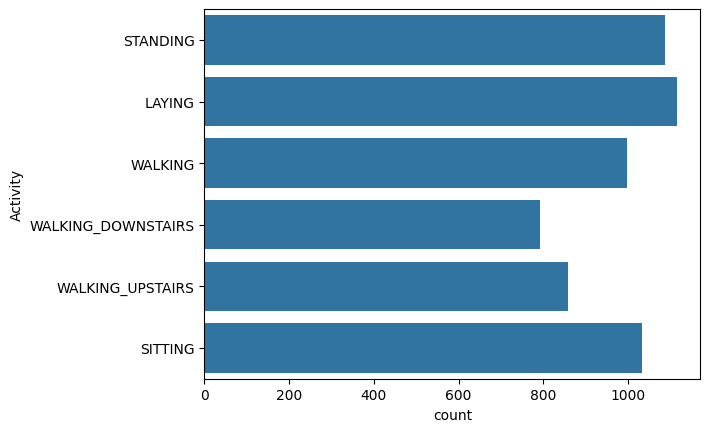

In [ ]:
sns.countplot(data=train_df, y='Activity') #'Activity'열의 갯수

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
from_sensor = {}
feature_sensor = ['Acc', 'Gyro']

for column in train_X.columns:     # feature 변수의 값 확인
  for sensor in feature_sensor:
    if sensor in column:
      if sensor not in from_sensor.keys():
        from_sensor[sensor] = []
      from_sensor[sensor].append(column)

for key, value in from_sensor.items():
  print(f'{key} : {len(value)}')

Acc : 345
Gyro : 213


In [ ]:
#센서 그룹 데이터의 'agg'변수의 값 확인
from_agg = {}
feature_agg = ['mean', 'std', 'mad', 'max', 'min', 'sma', 'energy', 'iqr', 'entropy', 'arcoeff',
                  'correlation', 'maxinds', 'meanfreq', 'skewness', 'kurtosis']

for column in train_X.columns:                               # 'agg'변수에 대한 모든 값
  for agg in feature_agg:
    if agg in column.lower():
      if agg not in from_agg.keys():
        from_agg[agg] = []
      from_agg[agg].append(column)

for key, value in from_agg.items():
  print(f'{key} : {len(value)}')

mean : 53
std : 33
mad : 33
max : 46
min : 33
sma : 17
energy : 159
iqr : 33
entropy : 33
arcoeff : 80
correlation : 15
maxinds : 13
meanfreq : 13
skewness : 13
kurtosis : 13


In [ ]:
#센서 그룹 데이터의 'axis'변수의 값 확인
from_axis = {}
feature_axis = ['X', 'Y', 'Z']

for column in train_X.columns:
  for axis in feature_axis:
    if axis in column:
      if axis not in from_axis.keys():
        from_axis[axis] = []
      from_axis[axis].append(column)                  # 'axis'변수에 대한 모든 값

for key, value in from_axis.items():
  print(f'{key} : {len(value)}')

X : 107
Y : 107
Z : 107


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
# 데이터 분할을 위한 전처리

#### 2) 모델링

In [ ]:
#생성
from sklearn.ensemble import RandomForestClassifier     #RandomForest를 통한 모델 분석 진행
model = RandomForestClassifier()

#학습
model.fit(train_X, train_y)

#평가
model.score(test_X, test_y)

0.9755268524813052

#### 3) 변수 중요도 추출

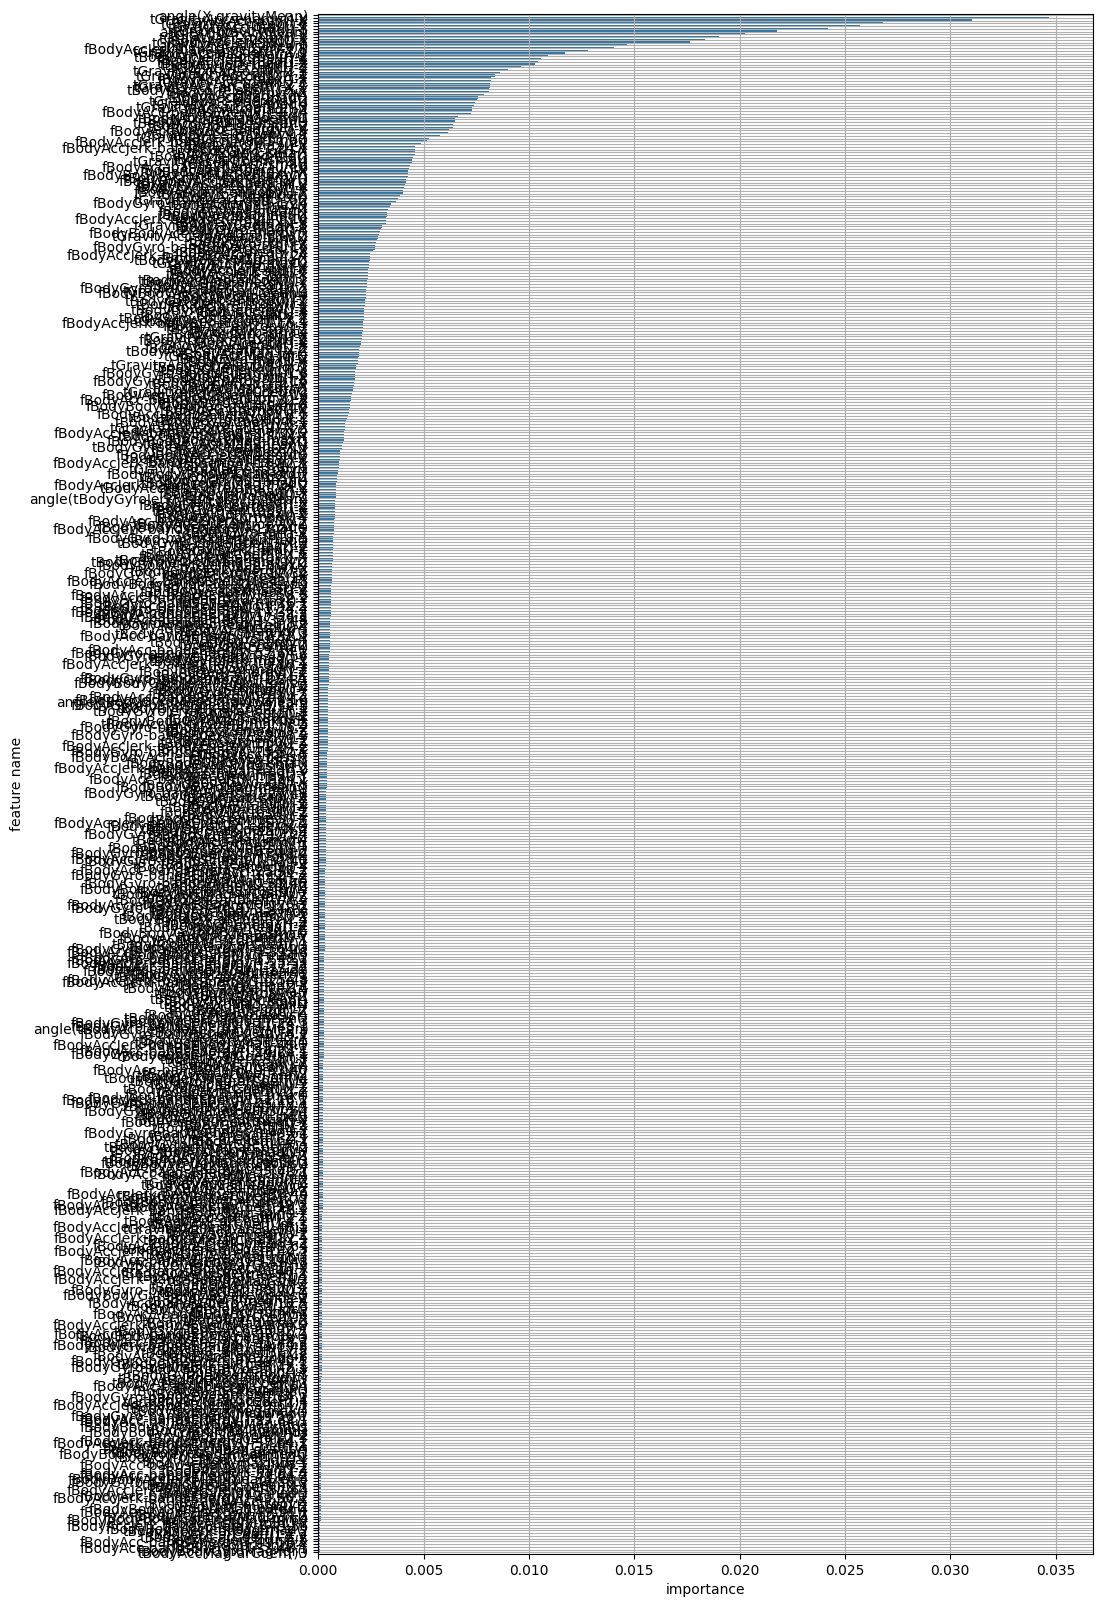

In [ ]:
# 변수 중요도 추출(시각화로 나타내기)
importances = model.feature_importances_
names = train_X.columns
result1 = plot_feature_importance(importances, names)       #시각화를 통한 변수 중요도를 추출

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 중요도 상위 top 5
result1.head(5)       #상위 top 5 선정

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.035030
1,tGravityAcc-energy()-X,0.034688
2,tGravityAcc-min()-X,0.031050
3,tGravityAcc-mean()-Y,0.026826
4,tGravityAcc-max()-X,0.025699


In [ ]:
# 중요도 하위 top 5
result1.tail(5)         #하위 top 5 선정

,feature_name,feature_importance
556,"fBodyAcc-bandsEnergy()-49,56.2",0.000093
557,fBodyAccJerk-iqr()-Y,0.000091
558,"fBodyAcc-bandsEnergy()-33,48.1",0.000088
559,fBodyBodyGyroMag-iqr(),0.000083
560,tBodyAccMag-arCoeff()3,0.000080


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

<Axes: xlabel='tGravityAcc-min()-X', ylabel='Density'>

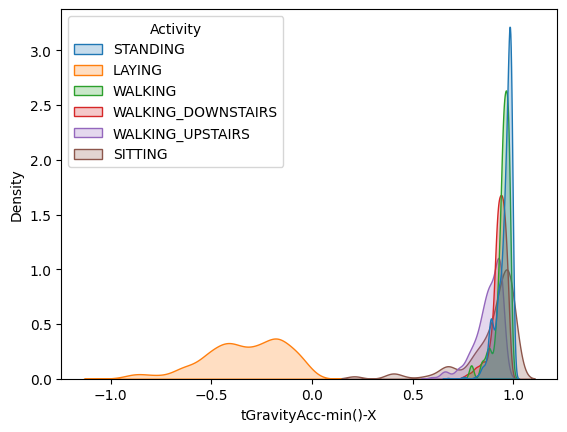

In [ ]:
#1위 : tGravityAcc-min()-X
sns.kdeplot(data=train_df, x='tGravityAcc-min()-X', hue='Activity', fill=True)
#kdeplot으로 표현한 상위 변수 5개와 target과의 관계

<Axes: xlabel='tGravityAcc-mean()-Y', ylabel='Density'>

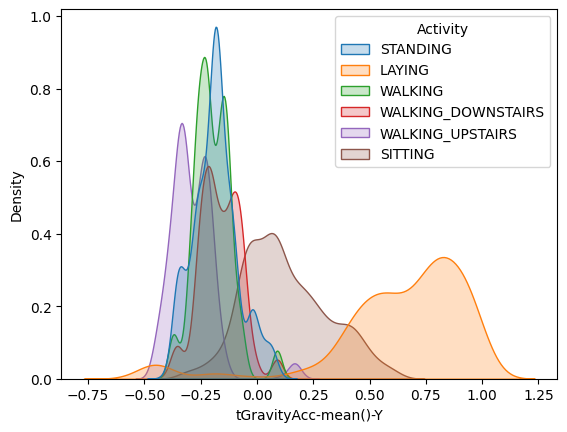

In [ ]:
#2위: tGravityAcc-mean()-Y
sns.kdeplot(data=train_df, x='tGravityAcc-mean()-Y', hue='Activity', fill=True)  #Y

<Axes: xlabel='tGravityAcc-max()-X', ylabel='Density'>

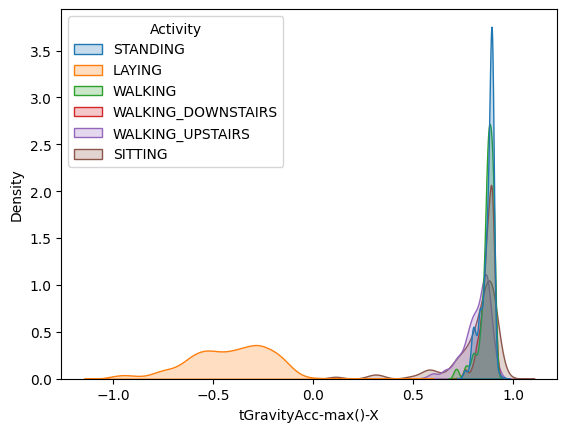

In [ ]:
#3위: tGravityAcc-max()-X
sns.kdeplot(data=train_df, x='tGravityAcc-max()-X', hue='Activity', fill=True)

<Axes: xlabel='angle(X,gravityMean)', ylabel='Density'>

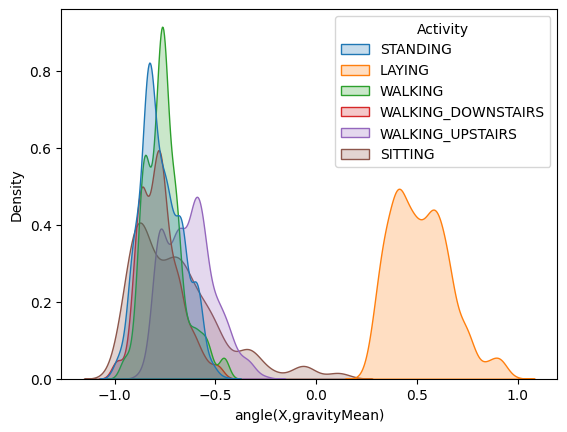

In [ ]:
#4위: angle(X,gravityMean)
sns.kdeplot(data=train_df, x='angle(X,gravityMean)', hue='Activity', fill=True)

<Axes: xlabel='tGravityAcc-max()-Y', ylabel='Density'>

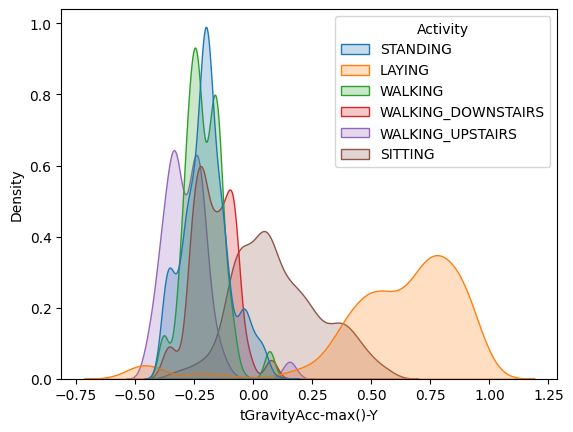

In [ ]:
#5위: tGravityAcc-max()-Y
sns.kdeplot(data=train_df, x='tGravityAcc-max()-Y', hue='Activity', fill=True)

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

<Axes: xlabel='fBodyAcc-entropy()-Z', ylabel='Density'>

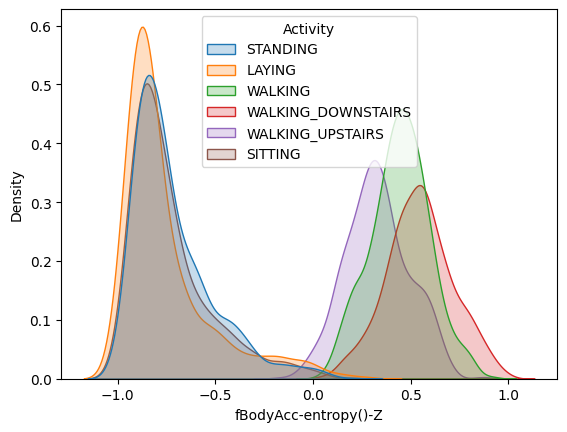

In [ ]:
#1위 : fBodyAcc-entropy()-Z
sns.kdeplot(data=train_df, x='fBodyAcc-entropy()-Z', hue='Activity', fill=True)
#kdeplot으로 표현한 하위 변수 5개와 target과의 관계

<Axes: xlabel='fBodyAcc-bandsEnergy()-49,56', ylabel='Density'>

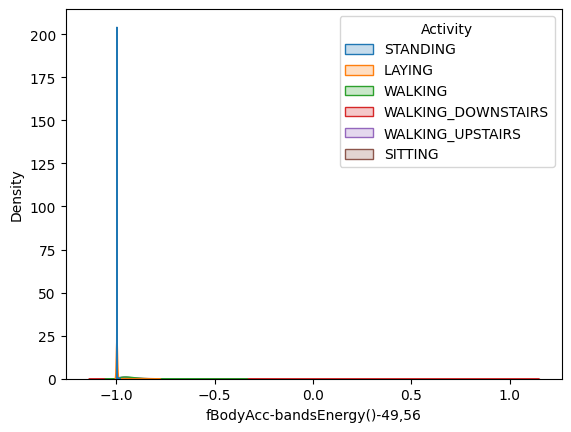

In [ ]:
#2위 : fBodyAcc-bandsEnergy()-49,56
sns.kdeplot(data=train_df, x='fBodyAcc-bandsEnergy()-49,56', hue='Activity', fill=True)
   #관련성이 거의 없다고 봄

<Axes: xlabel='fBodyAcc-bandsEnergy()-49,64.2', ylabel='Density'>

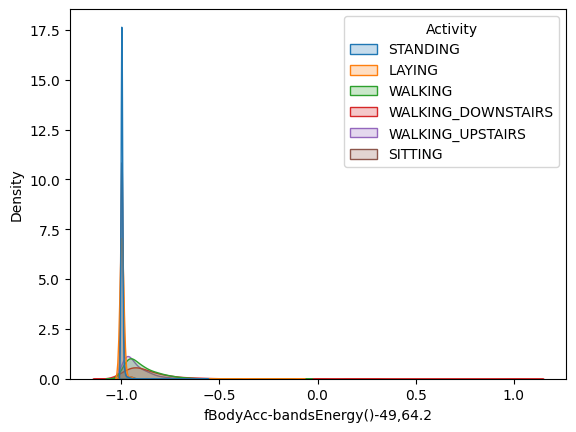

In [ ]:
#3위 : fBodyAcc-bandsEnergy()-49,64.2
sns.kdeplot(data=train_df, x='fBodyAcc-bandsEnergy()-49,64.2', hue='Activity', fill=True)

#미세한 관련성

<Axes: xlabel='fBodyAcc-bandsEnergy()-49,64', ylabel='Density'>

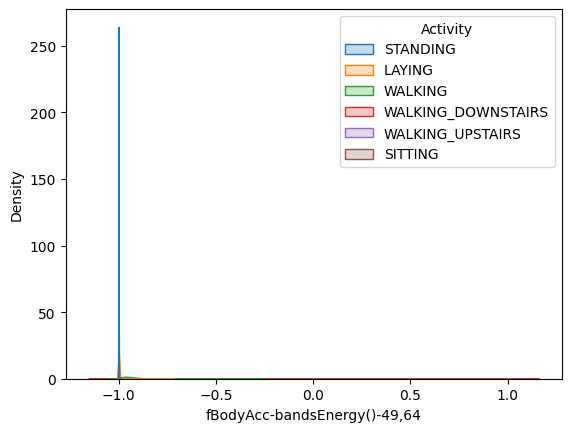

In [ ]:
#4위 : fBodyAcc-bandsEnergy()-49,64
sns.kdeplot(data=train_df, x='fBodyAcc-bandsEnergy()-49,64', hue='Activity', fill=True)
   #관련성이 거의 없다고 봄

<Axes: xlabel='fBodyAcc-entropy()-Y', ylabel='Density'>

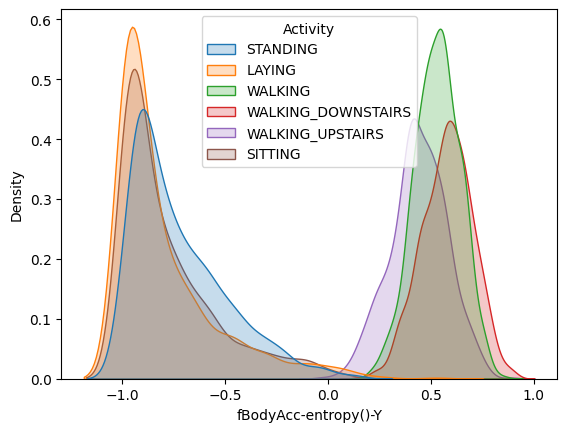

In [ ]:
#5위 : fBodyAcc-entropy()-Y
sns.kdeplot(data=train_df, x='fBodyAcc-entropy()-Y', hue='Activity', fill=True)
#가장 높은 관련성

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [ ]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)
is_dynamic = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
train_df['is_dynamic'] = train_df['Activity'].apply(lambda x: 1 if x in is_dynamic else 0)
test_df['is_dynamic'] = test_df['Activity'].apply(lambda x: 1 if x in is_dynamic else 0)
train_df.head(), test_df.head()

# is dynamic을 통해 정적,동적 데이터 구분

(   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
 0           0.288508          -0.009196          -0.103362         -0.988986   
 1           0.265757          -0.016576          -0.098163         -0.989551   
 2           0.278709          -0.014511          -0.108717         -0.997720   
 3           0.289795          -0.035536          -0.150354         -0.231727   
 4           0.394807           0.034098           0.091229          0.088489   
 
    tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
 0         -0.962797         -0.967422         -0.989000         -0.962596   
 1         -0.994636         -0.987435         -0.990189         -0.993870   
 2         -0.981088         -0.994008         -0.997934         -0.982187   
 3         -0.006412         -0.338117         -0.273557          0.014245   
 4         -0.106636         -0.388502         -0.010469         -0.109680   
 
    tBodyAcc-mad()-Z  tBodyAcc-max()-X  ..

#### 2) 기본모델 생성

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(train_df.drop(['Activity', 'is_dynamic'], axis=1),
                                                  train_df['is_dynamic'],
                                                  train_size=0.7,
                                                  random_state=7,
                                                  shuffle=True)

# 데이터 분할 진행

In [ ]:
#RandomForestClassifier로 모델링 진행
model = RandomForestClassifier()
model.fit(train_X, train_y)
model.score(val_X, val_y)

#RandomForestClassifier 모델링 진행

0.9994334277620397

#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,fBodyGyro-sma(),0.059794
1,fBodyAccJerk-mean()-X,0.049824
2,tBodyAccJerkMag-entropy(),0.049785
3,"fBodyAccJerk-bandsEnergy()-1,16",0.040264
4,"fBodyAccJerk-bandsEnergy()-1,8",0.040148


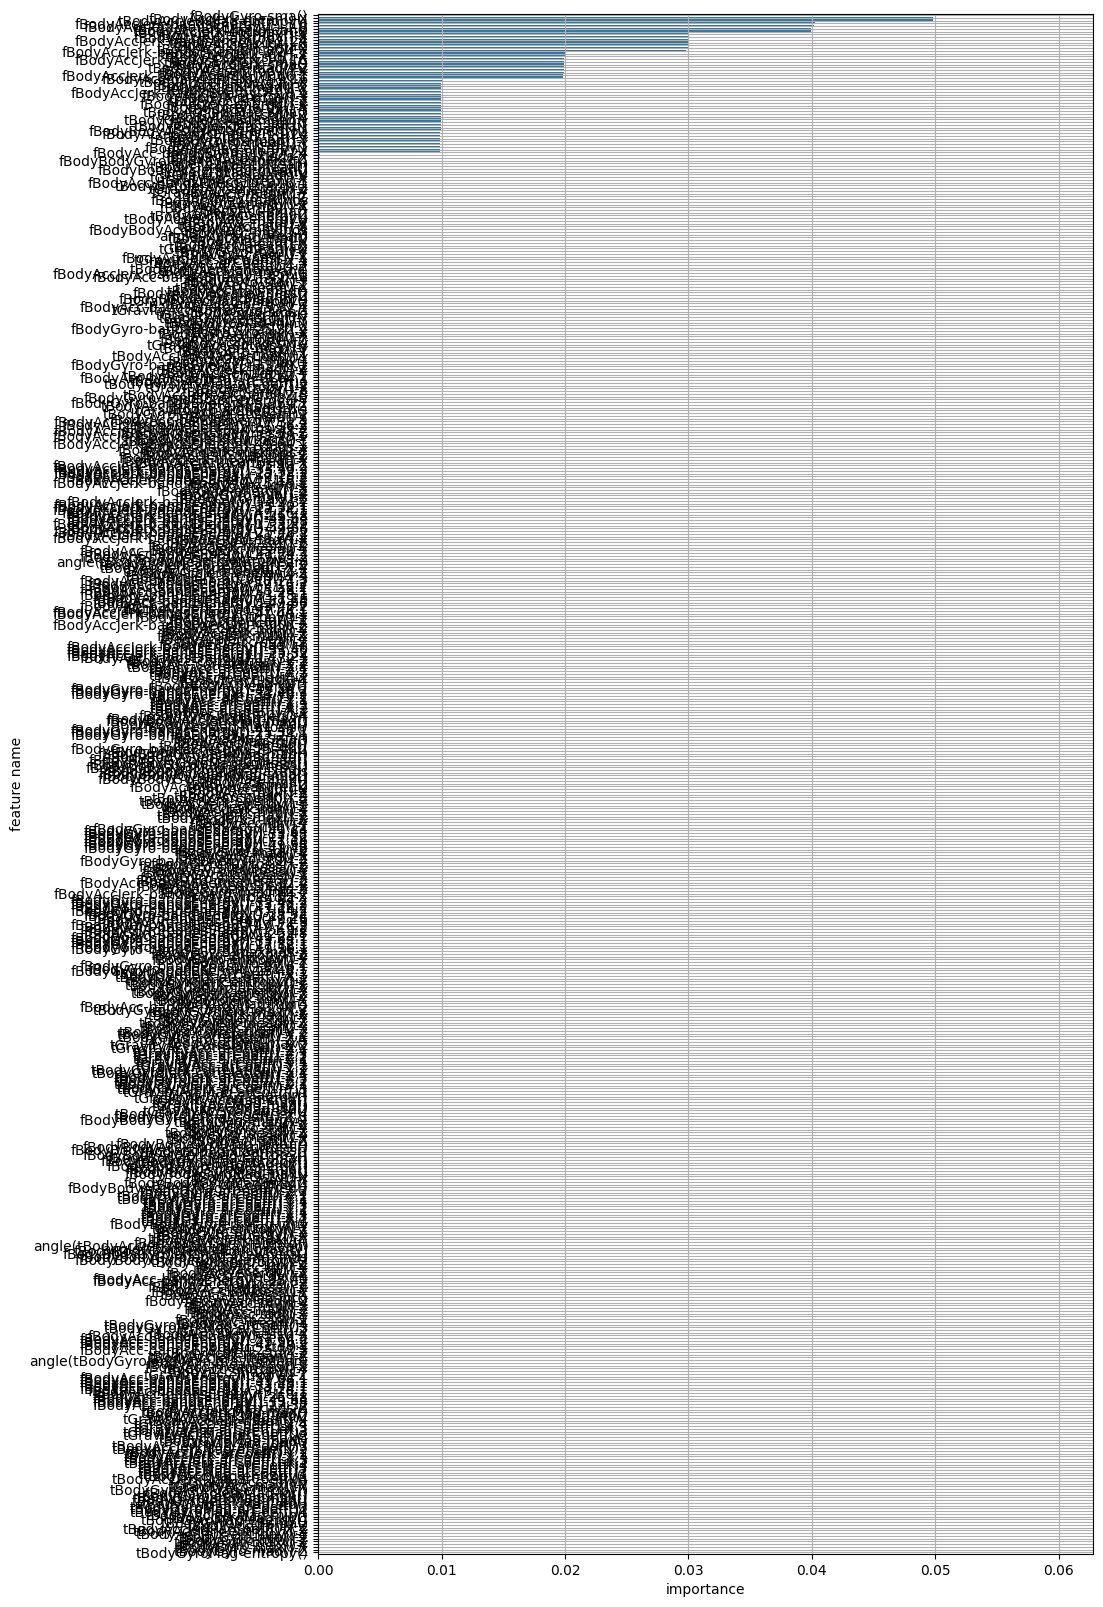

In [ ]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
names = train_X.columns
importances = model.feature_importances_
result2 = plot_feature_importance(importances, names)
result2.head(5)

#상위 변수 5를 분석

* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,16', ylabel='Density'>

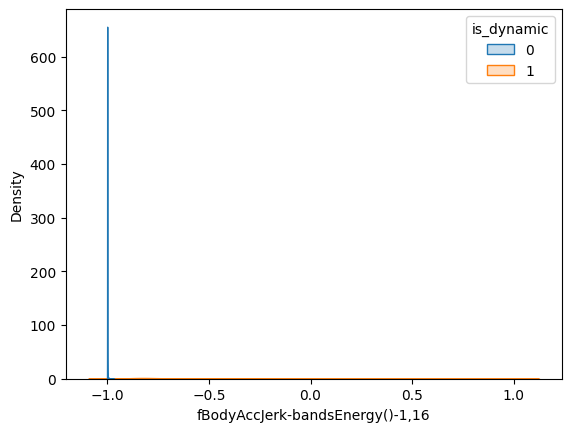

In [ ]:
#1위: fBodyAccJerk-bandsEnergy()-1,16
sns.kdeplot(data=train_df, x='fBodyAccJerk-bandsEnergy()-1,16', hue='is_dynamic', fill=True)

<Axes: xlabel='tBodyAccJerk-energy()-X', ylabel='Density'>

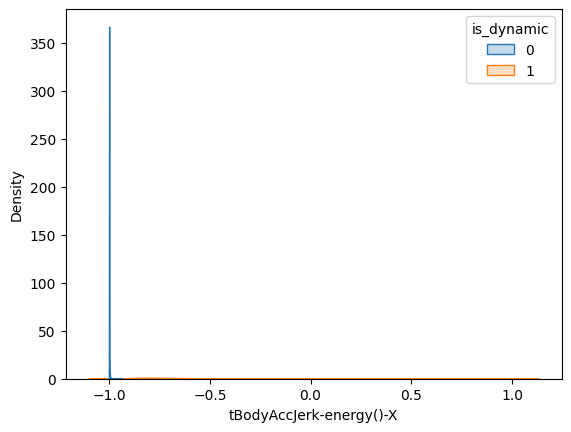

In [ ]:
#2위:tBodyAccJerk-energy()-X
sns.kdeplot(data=train_df, x='tBodyAccJerk-energy()-X', hue='is_dynamic', fill=True)

<Axes: xlabel='fBodyAcc-entropy()-X', ylabel='Density'>

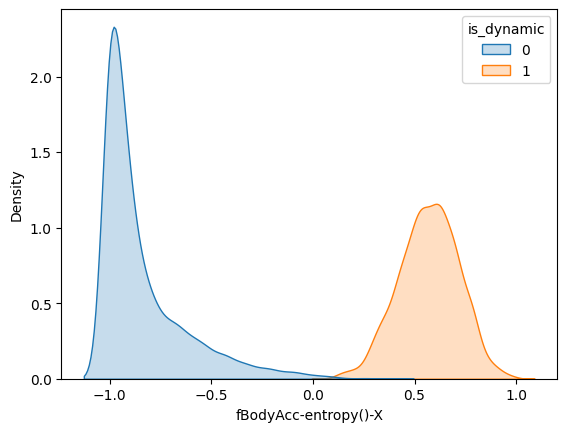

In [ ]:
#3위:fBodyAcc-entropy()-X
sns.kdeplot(data=train_df, x='fBodyAcc-entropy()-X', hue='is_dynamic', fill=True)

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,16.1', ylabel='Density'>

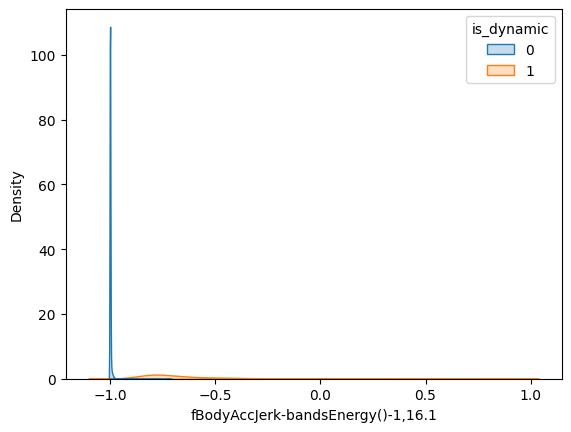

In [ ]:
#2위:fBodyAccJerk-bandsEnergy()-1,16.1
sns.kdeplot(data=train_df, x='fBodyAccJerk-bandsEnergy()-1,16.1', hue='is_dynamic', fill=True)

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,8', ylabel='Density'>

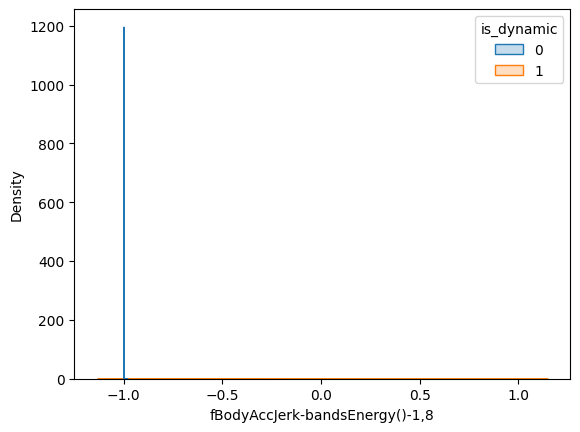

In [ ]:
#2위:fBodyAccJerk-bandsEnergy()-1,8
sns.kdeplot(data=train_df, x='fBodyAccJerk-bandsEnergy()-1,8', hue='is_dynamic', fill=True)

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
result1.head(), result2.head()
#이름변경을 위해서 데이터 불러옴

(             feature_name  feature_importance
 0    angle(X,gravityMean)            0.035030
 1  tGravityAcc-energy()-X            0.034688
 2     tGravityAcc-min()-X            0.031050
 3    tGravityAcc-mean()-Y            0.026826
 4     tGravityAcc-max()-X            0.025699,
                       feature_name  feature_importance
 0                  fBodyGyro-sma()            0.059794
 1            fBodyAccJerk-mean()-X            0.049824
 2        tBodyAccJerkMag-entropy()            0.049785
 3  fBodyAccJerk-bandsEnergy()-1,16            0.040264
 4   fBodyAccJerk-bandsEnergy()-1,8            0.040148)

In [ ]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
result1.rename(columns={'feature_importance': 'feature_importance_target6'}, inplace=True)
result2.rename(columns={'feature_importance': 'feature_importance_target2'}, inplace=True)

# 칼럼 이름 수정

#### 2) 합치기

In [ ]:
# merge 해서 2개를 합치는 작업하기
result = pd.merge(result1, result2, on='feature_name')
result.head()
# merge해서 2개를 합치는 작업

,feature_name,feature_importance_target6,feature_importance_target2
0,"angle(X,gravityMean)",0.035030,0.000108
1,tGravityAcc-energy()-X,0.034688,0.000088
2,tGravityAcc-min()-X,0.031050,0.000049
3,tGravityAcc-mean()-Y,0.026826,0.000088
4,tGravityAcc-max()-X,0.025699,0.000000


In [ ]:
result.count()
#최종적으로 나온 칼럼 갯수

,0
feature_name,561
feature_importance_target6,561
feature_importance_target2,561


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
joblib.dump(result, path + '/feature_importance.pkl')

['/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/feature_importance.pkl']

#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.